# setting up 

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob

import tarfile
import zipfile
import copy
import pandas as pd
import seaborn as sns

from FaceDetectorOpenCV import *
working_dir = 'C:/Users/101ma/Documents/emotion-recognition-transferlearning/'

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# load and show test images

In [2]:
test_dir = 'test_pics'
test_list = sorted(glob.glob(os.path.join(working_dir,test_dir,'*')))
test_images = []
for file in test_list:
    test_images.append(np.array(Image.open(file)))

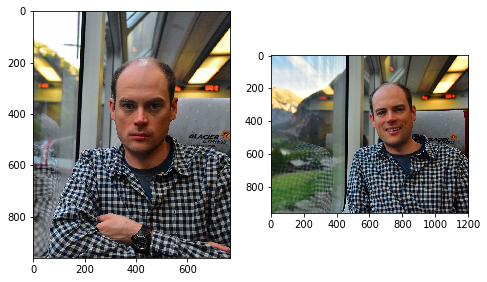

In [3]:
#show the images
show_image_num = 2 # how many images to show
plt.figure(0, figsize = (10, 8))
for image_id, image in enumerate(test_images[:show_image_num]):
    plt.subplot(1, len(test_images)+1, image_id+1)
    plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

# detect and crop faces

Face 0 dimension is: (200, 200, 3)
Face 1 dimension is: (200, 200, 3)


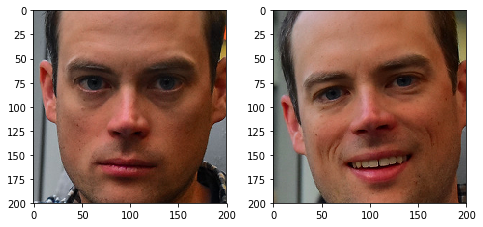

In [4]:
detector = FaceDetector(working_dir + "haarcascade_frontalface_default.xml")

# the width and height of the output face; could be set to (48,48)
resized_shape = (200,200)

# Could try 0.5 to see the effect
zoom_ratio = 0

cropped_faces = []
for image_id, image in enumerate(test_images):
    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord,resized_shape,zoom_ratio)
    for face in faces:
        cropped_faces.append(face)

# show the cropped faces
#show the images
plt.figure(0, figsize = (10, 8))
for face_id, face in enumerate(cropped_faces):
    plt.subplot(1, len(cropped_faces)+1, face_id+1)
    plt.imshow(face, cmap='gray')
    print('Face ' + str(face_id) + ' dimension is: ' + str(face.shape))
plt.tight_layout()
plt.show()
    

# setting up training data for EmoNet

In [5]:
#extract the tar file
tar_dir = tarfile.open(working_dir + 'fer2013.tar.gz', 'r:gz')
tar_dir.extractall(working_dir)

#dataset from kaggle challege read into a pandas dataframe
images_df = pd.read_csv(working_dir + 'fer2013/fer2013.csv')

#make a emotion dict that relates the emotion number with the expression
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
#see some descriptive statistics
images_df['emotion'].value_counts().rename(emotion_dict)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
#Setting up the training data
train_df = images_df[images_df['Usage'] == 'Training'][['emotion', 'pixels']]
train_df['pixels'] = train_df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

#df without 0s
index_0s = [i for i, x in enumerate(train_df['pixels']) if np.sum(x) == 0]
train_df = train_df[~train_df.index.isin(index_0s)].reset_index(drop = True)

x_train = np.vstack(train_df['pixels'].values)
y_train = np.array(train_df['emotion'])
print ('x_train shape is: ', x_train.shape)
print ('y_train shape is: ', y_train.shape)

x_train shape is:  (28698, 2304)
y_train shape is:  (28698,)


In [8]:
#Setting up the public test data
public_test_df = images_df[images_df['Usage'] == 'PublicTest'][['emotion', 'pixels']]
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_public_test = np.vstack(public_test_df['pixels'].values)
y_public_test = np.array(public_test_df['emotion'])
print('x_public_test shape is: ', x_public_test.shape)
print('y_public_test shape is: ', y_public_test.shape)

x_public_test shape is:  (3589, 2304)
y_public_test shape is:  (3589,)


In [9]:
#resahpe images to a 48 x 48 pixel matrix
#we need to flatten it to one channel though which is what the 1 at the 
#end does
x_train = x_train.reshape(-1, 48, 48, 1)
x_public_test = x_public_test.reshape(-1, 48, 48, 1)
print ('x_train new shape is: ', x_train.shape)
print ('x_test new shape is: ', x_public_test.shape)

x_train new shape is:  (28698, 48, 48, 1)
x_test new shape is:  (3589, 48, 48, 1)


In [10]:
#Make y categorical
y_train_cat= pd.get_dummies(y_train).as_matrix()
y_public_test_cat = pd.get_dummies(y_public_test).as_matrix()

C:\Users\101ma\Documents\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\101ma\Documents\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


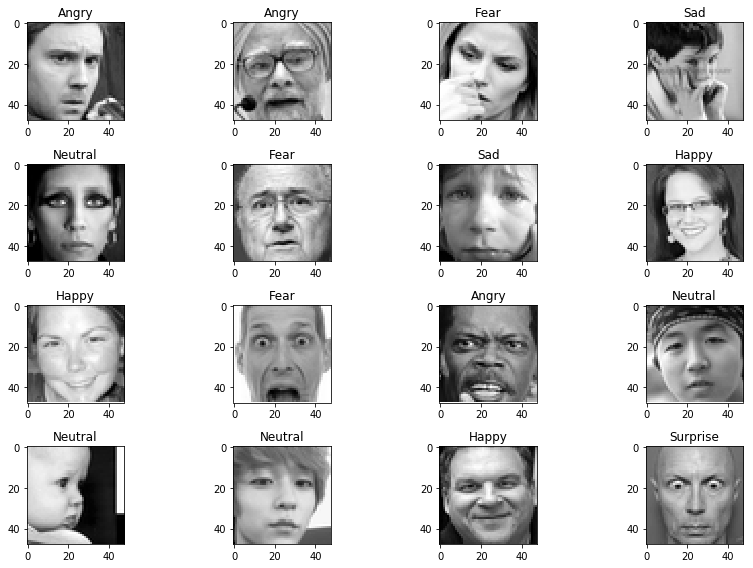

In [11]:
#show some images
plt.figure(0, figsize = (12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
    plt.title(emotion_dict[np.where(y_train_cat[i] == 1)[0][0]])
plt.tight_layout()
plt.show()

# set up EmoNet

This is the part where we will branch out and write our own code.